## MMTHE01 - Masters Thesis

### C. Thesis - Create a working model
* Splitting the data into train and test data
* Feature scaling by training on the 
* 

#### Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import time
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder

In [2]:
os.chdir(r'S:\Semester 4\Masters Thesis Report\6. Analysis')

#### Importing the dataset

In [3]:
dataset = pd.read_csv('train_dataset_final.csv')

In [4]:
dataset.head()

,isFraud,TransactionDT,TransactionAmt,card1,C3,C9,C12,C13,C14,TransactionID,...,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,M4_M0,M4_M1,M4_M2
0,0,86400,68.5,13926,0.0,1.0,0.0,1.0,1.0,2987000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0,86401,29.0,2755,0.0,0.0,0.0,1.0,1.0,2987001,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,86469,59.0,4663,0.0,1.0,0.0,1.0,1.0,2987002,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0,86499,50.0,18132,0.0,1.0,0.0,25.0,1.0,2987003,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0,86506,50.0,4497,0.0,0.0,0.0,1.0,1.0,2987004,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [5]:
dataset.shape

(590540, 201)

### 4.1 Split the data into Train-Test

#### 4.1.1 Separate the features and the label

In [6]:
dataset_final = dataset.drop('TransactionID', axis=1)

In [7]:
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:,0].values

In [8]:
from sklearn.model_selection import train_test_split
X_train_im, X_test, y_train_im, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 1)

### 4.2 Applying SMOTE

In [9]:
# Applying SMOTE only to the training data
smote = SMOTE(random_state=1)
X_train, y_train = smote.fit_resample(X_train_im, y_train_im)

### 4.3 Feature Scaling

#### 4.3.1 Checking if the data has outliers

In [10]:
# Detect outliers using IQR method for each column
def detect_iqr_outliers(df):
    outlier_flags = pd.DataFrame(False, index=df.index, columns=df.columns)

    for col in df.select_dtypes(include=[int, float]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Mark outliers
        outlier_flags[col] = (df[col] < lower_bound) | (df[col] > upper_bound)

    return outlier_flags

In [11]:
# Call the function
outliers_df = detect_iqr_outliers(dataset)

In [12]:
outlier_count_df = outliers_df.apply(lambda col: col.value_counts()).T

In [13]:
outlier_count_df.to_csv('outlier_count_df.csv')

#### 3.3.2 Feature Scaling

In [14]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### 4.4 Unsupervised Learning Models

#### 4.4.1 Isolation Forest

In [15]:
from sklearn.ensemble import IsolationForest

In [16]:
# Train Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.035,  # Approximate fraud ratio in dataset
    max_samples='auto',
    random_state=1,
    n_jobs=-1
)

In [17]:
start_time = time.time()

In [18]:
iso_forest.fit(X_train_scaled)

IsolationForest(contamination=0.035, n_jobs=-1, random_state=1)

In [19]:
end_time = time.time()
training_time = end_time - start_time
print(f"Isolation Forest Training Time: {training_time:.2f} seconds")

Isolation Forest Training Time: 14.35 seconds


In [20]:
# Predict: -1 for outliers (fraud), 1 for inliers (non-fraud)
y_pred = iso_forest.predict(X_test_scaled)

In [21]:
# Convert to 1 for fraud, 0 for non-fraud to match label
y_pred_binary = np.where(y_pred == -1, 1, 0)

In [22]:
# Use anomaly scores for ROC AUC
y_pred_proba = iso_forest.decision_function(X_test_scaled)*-1  # Higher score = more anomalous

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba,pos_label=1)
auc_score = auc(fpr, tpr)
print("Isolation Forest - with SMOTE AUC (in %):", auc_score*100)

Isolation Forest - with SMOTE AUC (in %): 73.98630828739117


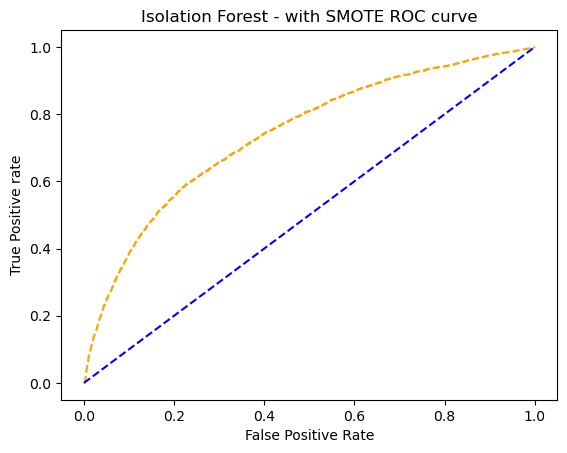

In [24]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y))]
p_fpr, p_tpr, thresholds = roc_curve(y, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Isolation Forest - with SMOTE ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('Isolation Forest - with SMOTE ROC curve',dpi=300)
plt.show()

In [25]:
### Calculate recall_score of the baseline model to determine its sensitivity

sensitivity = recall_score(y_test, y_pred_binary, pos_label=1)
print(f"Isolation Forest Recall Score (Sensitivity): {sensitivity:.4f}")

Isolation Forest Recall Score (Sensitivity): 0.0740


#### 4.4.2 Autoencoder

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [27]:
# NOTE: Training is done on only on non-fraudulent samples
X_train_ae = X_train_scaled[y_train == 0] 

In [28]:
# Build the autoencoder
input_dim = X_train_ae.shape[1]
encoding_dim = 32  # compressed representation size

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
encoded = layers.Dense(16, activation='relu')(encoded)

decoded = layers.Dense(encoding_dim, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [29]:
start_time = time.time()

In [30]:
# Train the autoencoder
history = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=2
)

Epoch 1/50
1603/1603 - 6s - 4ms/step - loss: 0.5199 - val_loss: 0.4035
Epoch 2/50
1603/1603 - 4s - 3ms/step - loss: 0.4092 - val_loss: 0.3747
Epoch 3/50
1603/1603 - 4s - 3ms/step - loss: 0.3771 - val_loss: 0.3592
Epoch 4/50
1603/1603 - 4s - 3ms/step - loss: 0.3475 - val_loss: 0.3506
Epoch 5/50
1603/1603 - 4s - 3ms/step - loss: 0.3399 - val_loss: 0.3417
Epoch 6/50
1603/1603 - 4s - 3ms/step - loss: 0.3287 - val_loss: 0.3452
Epoch 7/50
1603/1603 - 6s - 4ms/step - loss: 0.3391 - val_loss: 0.3342
Epoch 8/50
1603/1603 - 4s - 3ms/step - loss: 0.3186 - val_loss: 0.3289
Epoch 9/50
1603/1603 - 4s - 3ms/step - loss: 0.3170 - val_loss: 0.3266
Epoch 10/50
1603/1603 - 4s - 2ms/step - loss: 0.3106 - val_loss: 0.3229
Epoch 11/50
1603/1603 - 4s - 3ms/step - loss: 0.3088 - val_loss: 0.3228
Epoch 12/50
1603/1603 - 4s - 3ms/step - loss: 0.3071 - val_loss: 0.3207
Epoch 13/50
1603/1603 - 4s - 2ms/step - loss: 0.3106 - val_loss: 0.3205
Epoch 14/50
1603/1603 - 4s - 3ms/step - loss: 0.3065 - val_loss: 0.3213
E

In [31]:
end_time = time.time()
training_time = end_time - start_time
print(f"Autoencoder Training Time: {training_time:.2f} seconds")

Autoencoder Training Time: 227.70 seconds


In [32]:
# Compute reconstruction errors on test data
X_test_pred = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - X_test_pred, 2), axis=1)

3691/3691 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [33]:
# Evaluate anomaly detection performance
# A simple threshold for anomaly score
threshold = np.percentile(mse[y_test == 0], 95)  # 95th percentile of reconstruction error on non-fraud

In [34]:
# Predict fraud if reconstruction error > threshold
y_pred = (mse > threshold).astype(int)

In [35]:
y_pred_proba = mse

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba,pos_label=1)
auc_score = auc(fpr, tpr)
print("Autoencoder - with SMOTE AUC (in %):", auc_score*100)

Autoencoder - with SMOTE AUC (in %): 74.8558586677127


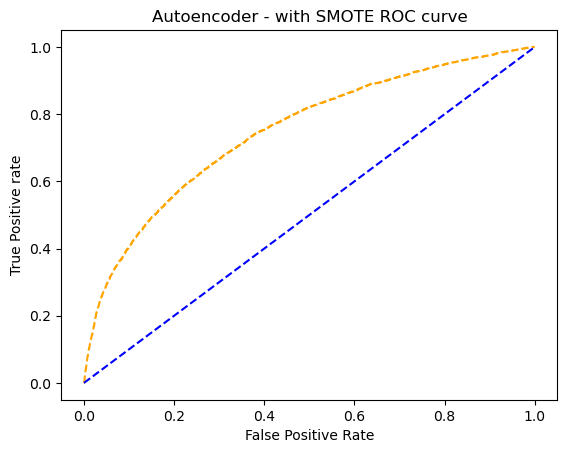

In [37]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Autoencoder - with SMOTE ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('Autoencoder - with SMOTE ROC curve',dpi=300)
plt.show()

In [38]:
### Calculate recall_score of the baseline model to determine its sensitivity

sensitivity = recall_score(y_test, y_pred, pos_label=1)
print(f"Autoencoder Recall Score (Sensitivity): {sensitivity:.4f}")

Autoencoder Recall Score (Sensitivity): 0.2920


### 4.5 Supervised Learning Models

#### 4.5.1 Random Forest (RF)

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
# Build a Random Forest Model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1, class_weight='balanced')

In [41]:
start_time = time.time()

In [42]:
# Train the Random Forest Model
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=1)

In [43]:
end_time = time.time()
training_time = end_time - start_time
print(f"Random Forest Training Time: {training_time:.2f} seconds")

Random Forest Training Time: 898.99 seconds


In [44]:
# Predict y given X_test
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1],pos_label=1)
auc_score = auc(fpr, tpr)
print("Random Forest - with SMOTE AUC (in %):", auc_score*100)

Random Forest - with SMOTE AUC (in %): 87.05815575947094


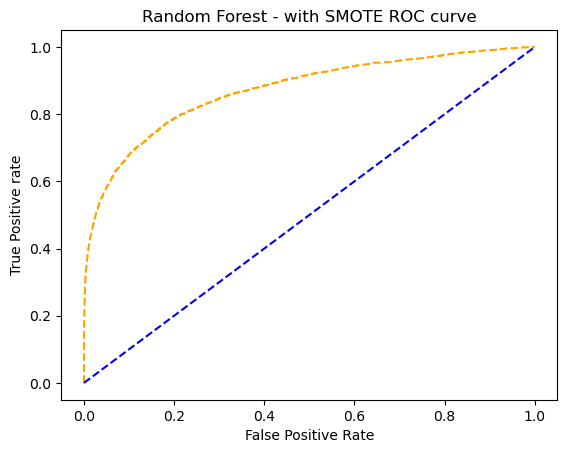

In [46]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('Random Forest - with SMOTE ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('Random Forest - with SMOTE ROC curve',dpi=300)
plt.show()

In [47]:
### Calculate recall_score of the baseline model to determine its sensitivity

sensitivity = recall_score(y_test, y_pred, pos_label=1)
print(f"Random Forest Recall Score (Sensitivity): {sensitivity:.4f}")

Random Forest Recall Score (Sensitivity): 0.4626


#### 4.5.2 XGBoost

In [48]:
from xgboost import XGBClassifier

In [49]:
# Build an XGBoost Model
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=5,  # Adjust based on imbalance
    eval_metric='auc',
    random_state=1
)

In [50]:
start_time = time.time()

In [51]:
# Train the XGBoost model
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [52]:
end_time = time.time()
training_time = end_time - start_time
print(f"XGBoost Training Time: {training_time:.2f} seconds")

XGBoost Training Time: 23.50 seconds


In [53]:
# Predict y given X_test
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1],pos_label=1)
auc_score = auc(fpr, tpr)
print("XGBoost - with SMOTE AUC (in %):", auc_score*100)

XGBoost - with SMOTE AUC (in %): 90.18545980498077


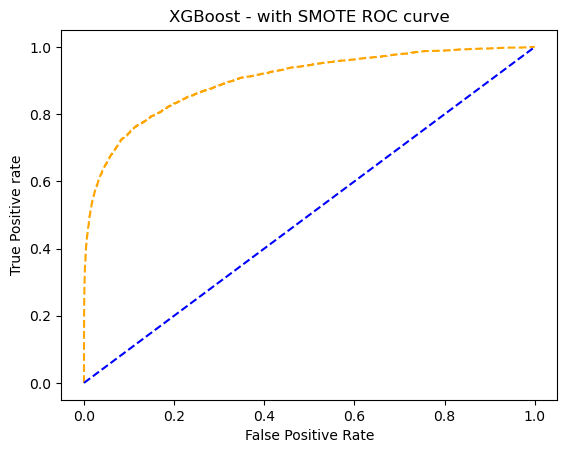

In [55]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('XGBoost - with SMOTE ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('XGBoost - with SMOTE ROC curve',dpi=300)
plt.show()

In [56]:
### Calculate recall_score of the baseline model to determine its sensitivity

sensitivity = recall_score(y_test, y_pred, pos_label=1)
print(f"XGBoost Recall Score (Sensitivity): {sensitivity:.4f}")

XGBoost Recall Score (Sensitivity): 0.6330


#### 4.5.3 Artificial Neural Network (ANN)

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [58]:
# Build an ANN model
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit Input layer instead of input_dim in Dense
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_AUC', patience=3, restore_best_weights=True, mode='max')

In [59]:
start_time = time.time()

In [60]:
# Train the ANN model with timing
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - AUC: 0.8849 - loss: 0.4019 - val_AUC: 0.0000e+00 - val_loss: 0.3302
Epoch 2/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - AUC: 0.9507 - loss: 0.2699 - val_AUC: 0.0000e+00 - val_loss: 0.2960
Epoch 3/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - AUC: 0.9606 - loss: 0.2405 - val_AUC: 0.0000e+00 - val_loss: 0.3075
Epoch 4/20
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - AUC: 0.9647 - loss: 0.2273 - val_AUC: 0.0000e+00 - val_loss: 0.2812


In [61]:
end_time = time.time()
training_time = end_time - start_time
print(f"ANN Training Time: {training_time:.2f} seconds")

ANN Training Time: 54.01 seconds


In [62]:
# Predict y given X_test_scaled
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

3691/3691 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [63]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba,pos_label=1)
auc_score = auc(fpr, tpr)
print("ANN - with SMOTE AUC (in %):", auc_score*100)

ANN - with SMOTE AUC (in %): 89.44131970396255


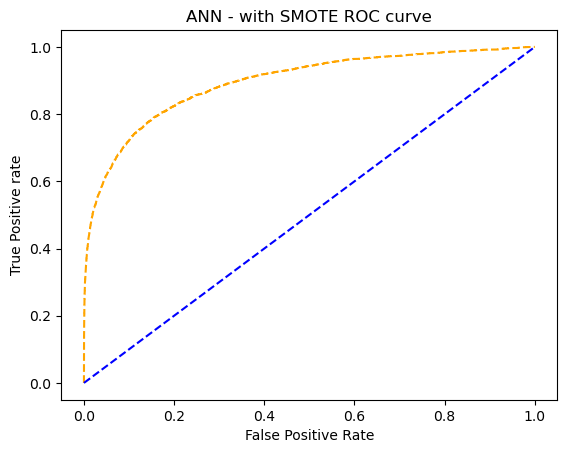

In [64]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ANN - with SMOTE ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('ANN - with SMOTE ROC curve',dpi=300)
plt.show()

In [65]:
### Calculate recall_score of the baseline model to determine its sensitivity

sensitivity = recall_score(y_test, y_pred, pos_label=1)
print(f"ANN Recall Score (Sensitivity): {sensitivity:.4f}")

ANN Recall Score (Sensitivity): 0.6368


#### 4.5.4 K Nearest Neighbour (KNN)

In [66]:
from sklearn.neighbors import KNeighborsClassifier

In [67]:
# Build a KNN model
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)

In [68]:
start_time = time.time()

In [69]:
# Train the KNN model
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_jobs=-1, weights='distance')

In [70]:
end_time = time.time()
training_time = end_time - start_time
print(f"KNN Training Time: {training_time:.2f} seconds")

KNN Training Time: 0.47 seconds


In [71]:
# Predict y given X_test_scaled
y_pred = knn.predict(X_test_scaled)
y_pred_proba = knn.predict_proba(X_test_scaled)

In [72]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1],pos_label=1)
auc_score = auc(fpr, tpr)
print("KNN - with SMOTE AUC (in %):", auc_score*100)

KNN - with SMOTE AUC (in %): 87.30367740282036


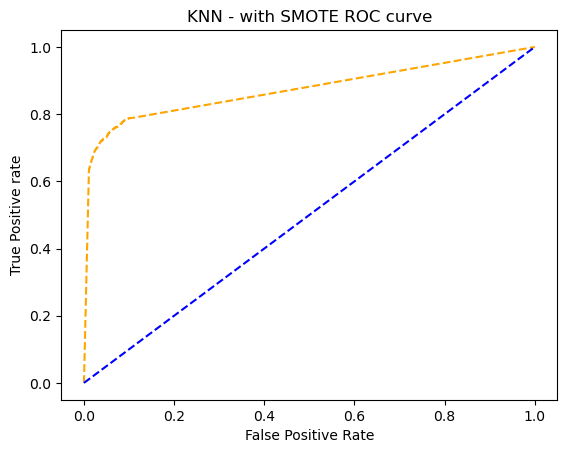

In [73]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('KNN - with SMOTE ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('KNN - with SMOTE ROC curve',dpi=300)
plt.show()

In [74]:
### Calculate recall_score of the baseline model to determine its sensitivity

sensitivity = recall_score(y_test, y_pred, pos_label=1)
print(f"KNN Recall Score (Sensitivity): {sensitivity:.4f}")

KNN Recall Score (Sensitivity): 0.7300


#### 4.5.5 Support Vector Machine (SVM) - Linear SVC

In [75]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

In [76]:
# Define pipeline with scaling + LinearSVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC(class_weight='balanced', max_iter=10000, random_state=42))
])

In [77]:
start_time = time.time()

In [78]:
# Fit the model
pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(class_weight='balanced', max_iter=10000,
                           random_state=42))])

In [79]:
end_time = time.time()
training_time = end_time - start_time
print(f"SVM Base Model Training Time: {training_time:.2f} seconds")

SVM Base Model Training Time: 155.07 seconds


In [80]:
# Predict y given X_test_scaled
y_pred = pipeline.predict(X_test_scaled)
y_pred_proba = pipeline.decision_function(X_test_scaled)

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba,pos_label=1)
auc_score = auc(fpr, tpr)
print("SVM - with SMOTE AUC (in %):", auc_score*100)

SVM - with SMOTE AUC (in %): 85.1528279359254


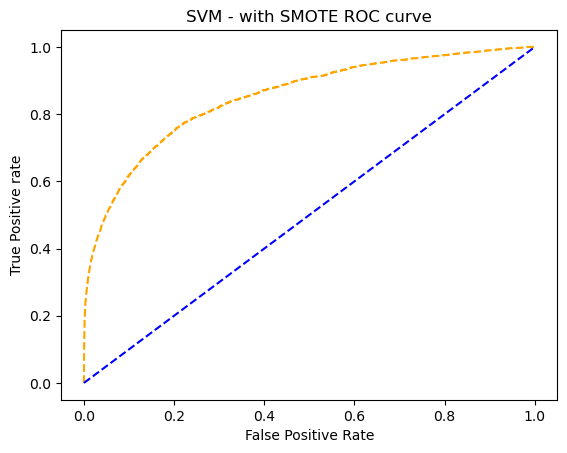

In [82]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('SVM - with SMOTE ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('SVM - with SMOTE ROC curve',dpi=300)
plt.show()

In [83]:
### Calculate recall_score of the baseline model to determine its sensitivity

sensitivity = recall_score(y_test, y_pred, pos_label=1)
print(f"GBM Recall Score (Sensitivity): {sensitivity:.4f}")

GBM Recall Score (Sensitivity): 0.7041


#### 4.5.6 Gradient Boosting Machine (GBM)

In [84]:
from sklearn.ensemble import GradientBoostingClassifier

In [85]:
# Define GBM model
gbm = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=1
)

In [86]:
start_time = time.time()

In [87]:
gbm.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, random_state=1, subsample=0.8)

In [88]:
end_time = time.time()
training_time = end_time - start_time
print(f"GBM Training Time: {training_time:.2f} seconds")

GBM Training Time: 8423.86 seconds


In [89]:
# Predict y given X_test
y_pred = gbm.predict(X_test)
y_pred_proba = gbm.predict_proba(X_test)

In [90]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1],pos_label=1)
auc_score = auc(fpr, tpr)
print("GBM - with SMOTE AUC (in %):", auc_score*100)

GBM - with SMOTE AUC (in %): 88.56126957008063


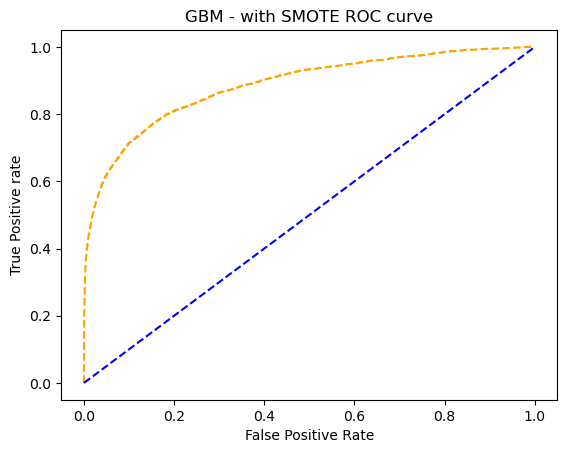

In [91]:
# ROC-AUC Curve
# plot roc curves
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr, tpr, linestyle='--', color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('GBM - with SMOTE ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.savefig('GBM - with SMOTE ROC curve',dpi=300)
plt.show()

In [92]:
### Calculate recall_score of the baseline model to determine its sensitivity

sensitivity = recall_score(y_test, y_pred, pos_label=1)
print(f"GBM Recall Score (Sensitivity): {sensitivity:.4f}")

GBM Recall Score (Sensitivity): 0.4108


### 3.7 Cross Validation Checks for the Supervised Learning Models

#### 3.7.1 Cross Validation for the Random Forest Model

In [93]:
from sklearn.model_selection import cross_val_score
aucs = cross_val_score(estimator = rf, X = X_train, y = y_train, cv = 10, scoring="roc_auc")
print("Accuracy Random Forest: {:.3f} %".format(aucs.mean()*100))
print("Standard Deviation Random Forest: {:.5f}".format(aucs.std()))

Accuracy Random Forest: 99.153 %
Standard Deviation Random Forest: 0.01369


In [94]:
recalls = cross_val_score(estimator = rf, X = X_train, y = y_train, cv = 10, scoring="recall")
print("Accuracy Random Forest: {:.4f}".format(recalls.mean()))
print("Standard Deviation Random Forest: {:.5f}".format(recalls.std()))

Accuracy Random Forest: 0.9442
Standard Deviation Random Forest: 0.05717


#### 3.7.2 Cross Validation for the XGBoost Model

In [95]:
aucs = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 10, scoring="roc_auc")
print("Accuracy XGBoost: {:.3f} %".format(aucs.mean()*100))
print("Standard Deviation XGBoost: {:.5f}".format(aucs.std()))

Accuracy XGBoost: 99.526 %
Standard Deviation XGBoost: 0.01270


In [96]:
recalls = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 10, scoring="recall")
print("Accuracy XGBoost: {:.4f}".format(recalls.mean()))
print("Standard Deviation XGBoost: {:.5f}".format(recalls.std()))

Accuracy XGBoost: 0.9786
Standard Deviation XGBoost: 0.05764


#### 3.7.3 Cross Validation for the KNN Model

In [97]:
aucs = cross_val_score(estimator = knn, X = X_train_scaled, y = y_train, cv = 10, scoring="roc_auc")
print("Accuracy KNN: {:.3f} %".format(aucs.mean()*100))
print("Standard Deviation KNN: {:.5f}".format(aucs.std()))

Accuracy KNN: 99.356 %
Standard Deviation KNN: 0.00019


In [98]:
recalls = cross_val_score(estimator = knn, X = X_train_scaled, y = y_train, cv = 10, scoring="recall")
print("Accuracy KNN: {:.4f}".format(recalls.mean()))
print("Standard Deviation KNN: {:.5f}".format(recalls.std()))

Accuracy KNN: 0.9993
Standard Deviation KNN: 0.00078


#### 3.7.4 Cross Validation for the SVM Model

In [99]:
aucs = cross_val_score(estimator = pipeline, X = X_train_scaled, y = y_train, cv = 10, scoring="roc_auc")
print("Accuracy SVM: {:.3f} %".format(aucs.mean()*100))
print("Standard Deviation SVM: {:.5f}".format(aucs.std()))

Accuracy SVM: 87.538 %
Standard Deviation SVM: 0.00314


In [100]:
recalls = cross_val_score(estimator = pipeline, X = X_train_scaled, y = y_train, cv = 10, scoring="recall")
print("Accuracy SVM: {:.4f}".format(recalls.mean()))
print("Standard Deviation SVM: {:.5f}".format(recalls.std()))

Accuracy SVM: 0.7353
Standard Deviation SVM: 0.00536


#### 3.7.5 Cross Validation for the GBM Model

In [101]:
aucs = cross_val_score(estimator = gbm, X = X_train, y = y_train, cv = 10, scoring="roc_auc")
print("Accuracy GBM: {:.3f} %".format(aucs.mean()*100))
print("Standard Deviation GBM: {:.5f}".format(aucs.std()))

Accuracy GBM: 99.479 %
Standard Deviation GBM: 0.01372


In [ ]:
recalls = cross_val_score(estimator = gbm, X = X_train, y = y_train, cv = 10, scoring="recall")
print("Accuracy GBM: {:.4f}".format(recalls.mean()))
print("Standard Deviation GBM: {:.5f}".format(recalls.std()))